# DIY Covid-19 Dashboard

The first graph in the dashboard shows the amount of daily Covid cases, deaths and hospital admissions for the four countries UK, Wales, Northern Ireland and Scotland

# Graph keys

Cases: The number of cases that are published on the date.

Hospital: The number of hospital admission that are published on the date.  

Death: the cumulative number of deaths that occurred after 28 days of a positive test.

The data provided is accurate as of 26/11/2020. To get the lastest data please use the refresh function


# Times series of Cases, Hospitalisation and Deaths per Day

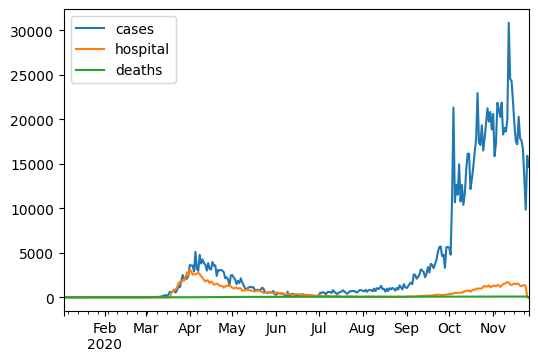

In [3]:
from uk_covid19 import Cov19API
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wdg
import datetime

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

def getDataChart1(country):
    countryChoice = "areaName=" + str(country)
    filters = ["areaType=nation", countryChoice]
    
    structure = {
    "date": "date",
    "cases": "newCasesByPublishDate",
    "hospital": "newAdmissions",
    "deaths": "cumDeaths28DaysByDeathDateRate"}

    api = Cov19API(filters=filters, structure=structure)
    timeseries = api.get_json()
    x = "timeseries" + str(country) + ".json"
    with open(x, "wt") as OUTF:
        json.dump(timeseries, OUTF)

def parse_date(datestring):
    return pd.to_datetime(datestring, format="%Y-%m-%d")

def wrangleDataChart1(jsonData):
    with open(str(jsonData), "rt") as INFILE:
        data=json.load(INFILE)
    datalist = data["data"]
    dates = [dictionary['date'] for dictionary in datalist ]
    dates.sort()
    sortedLists = [dates, datalist]
    return sortedLists

def createDataframeChart1(country):
    x = "timeseries" + str(country) + ".json"
    sortedList = wrangleDataChart1(x)
    dates = sortedList[0]
    datalist =sortedList[1]
    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])

    index=pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'hospital', 'deaths'])
    
    for entry in datalist:
        date = parse_date(entry["date"])
        for column in ['cases', 'hospital', 'deaths']:
            if pd.isna(timeseriesdf.loc[date, column]):
                value= float(entry[column]) if entry[column]!=None else 0.0
                timeseriesdf.loc[date, column]=value
    timeseriesdf.fillna(0.0, inplace=True)
    y = "timeseriesdf" + str(country) + ".pkl"
    timeseriesdf.to_pickle(y)

series = wdg.SelectMultiple(
    options=['cases', 'hospital', 'deaths'],
    value=['cases', 'hospital', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale = wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

country = wdg.RadioButtons(
    options=['England', 'Scotland', 'Wales', 'Northern Ireland'],
    value = 'England',
    description='Countries:',
    disabled=False
)

apibutton = wdg.Button(
    description = "Refresh data",
    disable = False,
    button_style = "",
    tooltip = "Click to get the lastest Public Health England data",
    icon = "refresh"
)

output = wdg.Output()

@output.capture()
def on_button_clicked(button):
    x = datetime.datetime.now()
    y = "This is the lastest data as of " + str(x)
    print(y, end="\r")
    
    

def access_api(button):
    countryChoice = country.value
    getDataChart1(countryChoice)
    createDataframeChart1(countryChoice)
    y = "timeseriesdf" + str(countryChoice) + ".pkl"
    global timeseriesdf
    timeseriesdf=pd.read_pickle(y)

    current=scale.value
    if current==scale.options[0]:
        other=scale.options[1]
    else:
        other=scale.options[0]
    scale.value=other 
    scale.value=current 
    
   
apibutton.on_click(access_api)
apibutton.on_click(on_button_clicked)
display(output)

def timeseries_graph(gcols, gscale, country):
    createDataframeChart1(country)
    y = "timeseriesdf" + str(country) + ".pkl"
    timeseriesdf=pd.read_pickle(y)
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)

    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

def createChart1():
    graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale, 'country': country})
    
    controls = wdg.VBox([series, scale, country, apibutton])
    form=wdg.HBox([graph, controls])
    display(form)

createChart1()

(C) 2020 Phu Pham (ec20104@qmul.ac.uk - Student ID: 200773869), all rights reserved